In [1]:
import os, sys
sys.path.insert(0, '/Users/weizheng/Programming/Django/evalstock')
os.environ.setdefault("DJANGO_SETTINGS_MODULE", "evalstock.settings")

import django
django.setup()

In [2]:
import matplotlib as mpl
import matplotlib.font_manager as font_manager
import matplotlib.pyplot as plt

# Setup default matplotlib chinese font
font_name = './STHeiti_Medium_1.ttf'
font_prop = font_manager.FontProperties(fname=font_name)
mpl.rcParams['font.family'] = font_prop.get_name()
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['figure.figsize'] = (20.0, 10.0)

In [3]:
import pandas as pd
import numpy as np
from django.db.models import Q

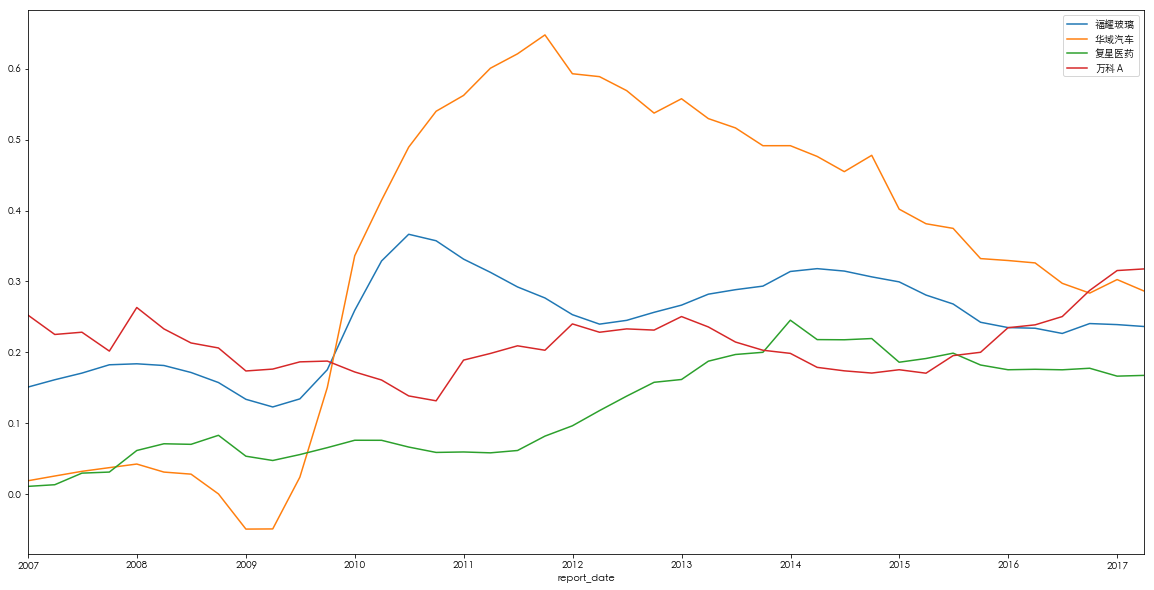

In [25]:
from magic_formula.models import HistoricalKpi

def show_roce_ttms(stock_names: list):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    for stock_name in stock_names:
        historical_kpi = HistoricalKpi.objects.filter(stock__stock_name=stock_name)
        roce_ttm_df = (pd.DataFrame(list(historical_kpi.values(
            'stock__stock_name', 'report_date', 'roce_ttm')))
            .set_index('report_date'))
        roce_ttm_df['roce_ttm'].plot(label=roce_ttm_df['stock__stock_name'][-1])

    plt.legend()
    plt.show()

show_roce_ttms(['福耀玻璃', '华域汽车', '复星医药', '万科Ａ'])

计算 TTM（Trailing Twelve Months）数据所需的辅助函数

In [5]:
import datetime

def find_trailing_year_dates(end_date: datetime.date) -> tuple:
    if end_date.month == 12:
        return end_date,

    return (datetime.date(end_date.year - 1, end_date.month, end_date.day),
            datetime.date(end_date.year - 1, 12, 31),
            end_date)

def cal_trailing_year_series(input_series: pd.Series) -> pd.Series:
    result_dict = {}
    for report_date, value in input_series.iteritems():
        ttm_dates = find_trailing_year_dates(report_date)
        if len(ttm_dates) == 1:
            result_dict[report_date] = input_series[report_date]
        else:
            begin_date, annual_report_date, end_date = ttm_dates
            if (begin_date in input_series.index
                    and annual_report_date in input_series.index):
                result_dict[report_date] = (input_series[annual_report_date]
                                            - input_series[begin_date]
                                            + input_series[end_date])
            else:
                result_dict[report_date] = np.nan
    return pd.Series(result_dict)

计算股票的杜邦分析数据

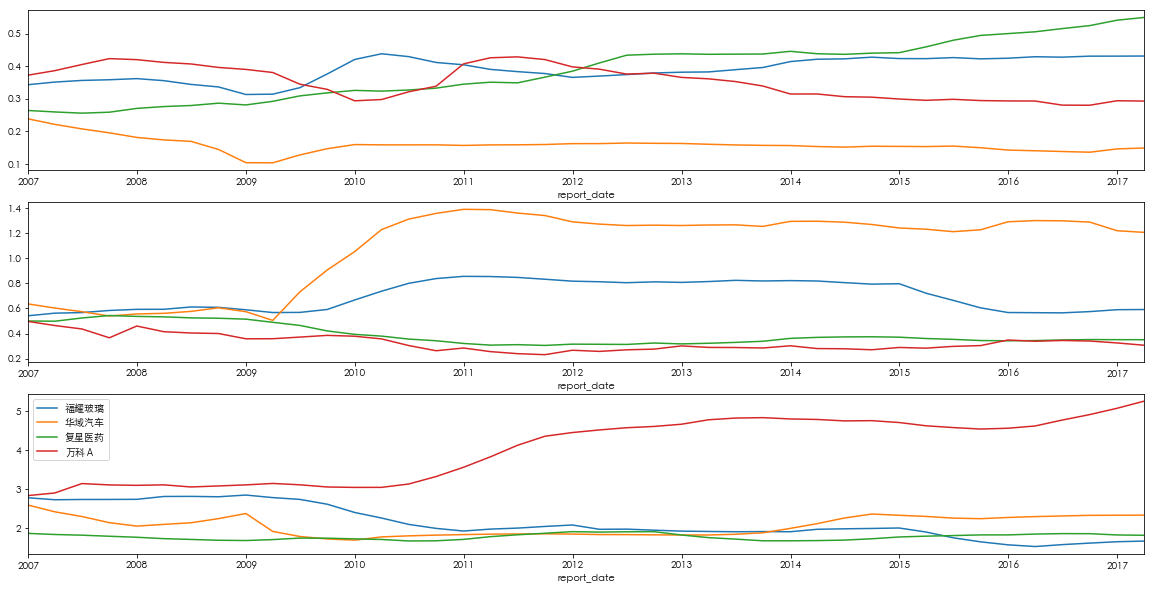

In [26]:
from finance_report.models import (Stock, ChinaBalanceSheet, ChinaCashFlowStatement, ChinaIncomeStatement) 
from dopont_analysis.models import LatestIndex, HistoricalKpi

def plot_gross_margin_ttm(stock_names):
    for stock_name in stock_names:    
        historical_kpi = HistoricalKpi.objects.filter(stock__stock_name=stock_name)
        gross_margin_ttm_df = (pd.DataFrame(list(historical_kpi.values(
            'stock__stock_name', 'report_date', 'gross_margin_ttm')))
            .set_index('report_date'))
        
        gross_margin_ttm_df['gross_margin_ttm'].plot(
            label=stock_name)

def plot_asset_turnover_ttm(stock_names):
    for stock_name in stock_names:    
        historical_kpi = HistoricalKpi.objects.filter(stock__stock_name=stock_name)
        asset_turnover_ttm_df = (pd.DataFrame(list(historical_kpi.values(
            'stock__stock_name', 'report_date', 'asset_turnover_ttm')))
            .set_index('report_date'))
        
        asset_turnover_ttm_df['asset_turnover_ttm'].plot(
            label=stock_name)

def plot_equity_multiplier_ttm(stock_names):
    for stock_name in stock_names:    
        historical_kpi = HistoricalKpi.objects.filter(stock__stock_name=stock_name)
        equity_multiplier_ttm_df = (pd.DataFrame(list(historical_kpi.values(
            'stock__stock_name', 'report_date', 'equity_multiplier_ttm')))
            .set_index('report_date'))
        
        equity_multiplier_ttm_df['equity_multiplier_ttm'].plot(
            label=stock_name)
        
fig = plt.figure()

fig.add_subplot(3, 1, 1)
plot_gross_margin_ttm(['福耀玻璃', '华域汽车', '复星医药', '万科Ａ'])

fig.add_subplot(3, 1, 2)
plot_asset_turnover_ttm(['福耀玻璃', '华域汽车', '复星医药', '万科Ａ'])

fig.add_subplot(3, 1, 3)
plot_equity_multiplier_ttm(['福耀玻璃', '华域汽车', '复星医药', '万科Ａ'])

plt.legend()
plt.show()

计算股票的其他重要财务数据

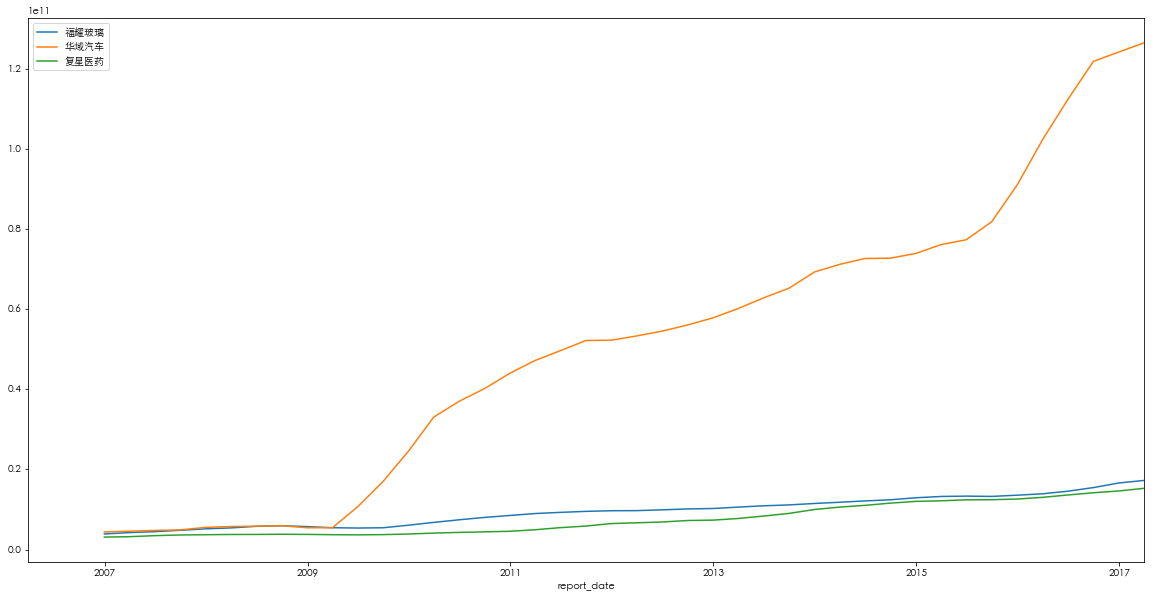

In [21]:
from finance_report.models import (Stock, ChinaBalanceSheet, ChinaCashFlowStatement, ChinaIncomeStatement) 

def plot_operations_income_ttms(stock_names):
    for stock_name in stock_names:    
        income_statements = ChinaIncomeStatement.objects.filter(
                                stock__stock_name=stock_name,
                                report_date__gt=datetime.date(2006, 1, 1))
        income_statements_df = (pd.DataFrame(list(income_statements.values()))
                                  .set_index('report_date')
                                  .sort_index())
        income_statements_df.loc[:, 'operations_income_ttm'] = cal_trailing_year_series(
            income_statements_df['operations_income'])

        income_statements_df['operations_income_ttm'].plot(
            label=stock_name)
    
fig = plt.figure()
fig.add_subplot(1, 1, 1)
plot_operations_income_ttms(['福耀玻璃', '华域汽车', '复星医药', '万科Ａ'])

plt.legend()
plt.show()